# Camera calibration & 3D reconstruction

***Maximum possible score = 100 points***

### Assignment Overview
This assignment has been broadly divided into two sections: 
In the first part, two images of the same object, taken from a pair of calibrated cameras, will be used to triangulate the 3D coordinates of points on the object. In the second part, two smartphone cameras will be calibrated using a set of chessboard patterns.

### Learning Objectives 
* Describe the basic principles of triangulation and epipolar geometry; reconstruct 3D scene structures from two images.


# Table of Contents 

### [Part 1: 3D Reconstruction [70 pts]](#part-1)
- [Eight point algorithm [30 pts]](#q1)
- 3D Scene Structure
    - [Essential Matrix [20 pts]](#q2)
    - [Epipolar Correspondence [0 pts]](#q3)
    - [Triangulation [20 pts]](#q4)

### [Part 2: Camera calibration and 3D reconstruction [30 pts]](#part-2)
- [Checkerboard pattern detection and Camera Calibration [15 pts]](#q5)
- [Feature descriptor matching and Fundamental Matrix estimation [15 pts]](#q6)

### [Part 3: Challenge Questions](#part-3)

<a name="part-1"></a>
## 3D reconstruction

For this section, we will use two images from the popular [Middlebury dataset](https://vision.middlebury.edu/stereo/data/). Let's first load them and then do a side-by-side comparison of the images. 

In [1]:
from pathlib import Path
# Change this path to point to the root of the project.
# Nothing else needs to be changed
root = Path(".").absolute()

In [2]:
from skimage import io
im1 = io.imread(root / "data" / "temple1.png")
im2 = io.imread(root / "data" / "temple2.png")

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

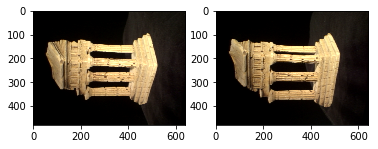

In [4]:
import matplotlib.pyplot as plt
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im2)
plt.show()

While the two images look similar, if you point to the same location on the object in the two images, you will see a slight difference in the coordinates of the two points. This is more evident when you go back and forth between the two images.

For this part of the assignment we provide you a set of point correspondences between the two images in the form of a `npz` file.

In [5]:
import numpy as np
np.random.seed(1)

points = np.load(root / "data" / "temple_corresp.npz")
points1 = points["pts1"]
points2 = points["pts2"]

Lets try to visualize the points on the two images.

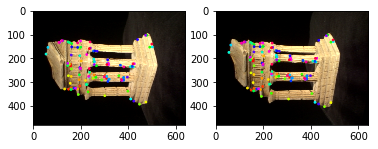

In [6]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im2)
cmap = plt.cm.get_cmap("hsv", len(points1))
ax1.scatter(points1[:,0], points1[:,1], s=3, c=[cmap(i) for i in range(len(points1))])
ax2.scatter(points2[:,0], points2[:,1], s=3, c=[cmap(i) for i in range(len(points2))])
plt.show()

<a name="q1"></a>
## Eight point algorithm [30 points]
Let us now implement the 8-point algorithm we learned in class.

You may find it helpful to refine the solution by using local minimization. This probably won't fix a completely broken solution, but may make a good solution better by locally minimizing a geometric cost function.

We provide a helper function `refineF` that will take in `F` and two sets of points, which you can call from `eightpoint` before unscaling `F`.

In [7]:
import scipy.optimize

def _singularize(F):
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U.dot(np.diag(S).dot(V))
    return F

def _objective_F(f, pts1, pts2):
    F = _singularize(f.reshape([3, 3]))
    num_points = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([num_points, 1])], axis=1)
    hpts2 = np.concatenate([pts2, np.ones([num_points, 1])], axis=1)
    Fp1 = F.dot(hpts1.T)
    FTp2 = F.T.dot(hpts2.T)

    r = 0
    for fp1, fp2, hp2 in zip(Fp1.T, FTp2.T, hpts2):
        r += (hp2.dot(fp1))**2 * (1 / (fp1[0]**2 + fp1[1]**2) + 1 /
                                  (fp2[0]**2 + fp2[1]**2))
    return r

def refineF(F, pts1, pts2):
    f = scipy.optimize.fmin_powell(lambda x: _objective_F(x, pts1, pts2),
                                   F.reshape([-1]),
                                   maxiter=100000,
                                   maxfun=10000,
                                   disp=False)
    return _singularize(f.reshape([3, 3]))

Define a function `eightpoint` that takes in 3 arguments &mdash; `pts1`, `pts2`, `M` where `pts1` and `pts2` are $N \times 2$ matrices corresponding to the $(x, y)$ coordinates of the N points in the first and second image respectively, and `M` is a scale parameter.

**Hint 1:** Use the scale parameter to scale down/normalize the point coordinates, find the $\boldsymbol{F}$ matrix using SVD and then scale the data back to undo the effect of normalization &mdash;
$$ \boldsymbol{x}_{normalized} = \boldsymbol{T}\boldsymbol{x}$$
$$ \boldsymbol{F}_{unnormalized} = \boldsymbol{T}^T\boldsymbol{F}\boldsymbol{T} $$
where $\boldsymbol{T}$ is a $3 \times 3$ diagonal matrix formed from `M`.

**Hint 2:** You must enforce the singularity condition of $\boldsymbol{F}$ before unscaling it. You may use the `_singularize` helper function provided above appropriately.

In [8]:
### GRADED
### YOUR ANSWER BELOW

"""

Note that the two hints were already implemented in the supplied code. 
 
**Hint 1:** 
    Use the scale parameter to scale down/normalize the point coordinates, 
    find the  F  matrix using SVD and then scale the data back 
    to undo the effect of normalization &mdash;
    {x normalized} =  Tx  
    {F unnormalized} =   ^T {F} {T}  
    where  T  is a 3x3 diagonal matrix formed from `M`.

**Hint 2:** 
    You must enforce the singularity condition of F before unscaling it. 
    You may use the `_singularize` helper function provided above appropriately.


"""

### YOUR SOLUTION HERE

def eightpoint(pts1, pts2, M):
    # normalize the coordinates
    x1, y1 = pts1[:, 0], pts1[:, 1]
    x2, y2 = pts2[:, 0], pts2[:, 1] 
    
    ############################################
    # STEP 0, normalize  
    ############################################
    x1, y1, x2, y2 = x1 / M, y1 / M, x2 / M, y2 / M
    # normalization matrix (that will be used later to denormalize)
    T = np.array([[1. / M, 0, 0], [0, 1. / M, 0], [0, 0, 1]])
    
    ############################################
    # STEP 1, create array of equations  
    ############################################
    A = np.transpose(
        np.vstack((x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1,
                   np.ones(x1.shape))))

    
    ########################################################################################
    ############################################ custom code ## start ## 
    
    ############################################
    # STEP 2, solving for F (from A) using SVD 
    # get F using SVD decomposition 
    _, _, vh = np.linalg.svd(A) 
    
    ############################################
    # STEP 3
    # Extract the fundamental matrix from the last column of v,
    # which is the last row of the vh,
    # under the premise that the last column is the 
    # least singular value
    F = vh[-1, :].reshape(3, 3) 
 
    ############################################ custom code ## end ##
    ########################################################################################

    ############################################
    # NOT SURE WHICH STEP THIS FITS INTO
    # refine F 
    F = refineF(F, pts1 / M, pts2 / M)

    ############################################
    # STEP 4, enforce rank 2 constraints
    # constraint of rank 2 by setting the last singular value to 0
    F = _singularize(F)


    ############################################
    # STEP 5, denormalize
    # rescale the data 
    F = np.dot(np.transpose(T), np.dot(F, T))

    return F

# YOUR CODE HERE

def mytest_1_eightpoint():  
    
    np.random.seed(0)
    _points = np.load(root / "data" / "temple_corresp.npz")
    _pts1 = _points["pts1"]
    _pts2 = _points["pts2"]
    _im1 = io.imread(root / "data" / "temple1.png")
    _im2 = io.imread(root / "data" / "temple2.png")
    _M = np.max(_im1.shape)
    
    F8 = eightpoint(_pts1, _pts2, _M)
    
    expected = np.array([[ 9.78833288e-10, -1.32135929e-07, 1.12585666e-03],
                         [-5.73843315e-08, 2.96800276e-09, -1.17611996e-05],
                         [-1.08269003e-03, 3.04846703e-05, -4.47032655e-03]])
    
    assert(F8.shape == expected.shape) 
    tolerance = 0.1**7
    print('Results matched expectations to a tolerance of', tolerance, '?', np.allclose(F8, expected, atol = tolerance)) 
    
def mytest_2_eightpoint():  
    M = np.max([np.max(points1),np.max(points2)]) 
    F = eightpoint(points1, points2, M)
    print(F)
    
mytest_1_eightpoint()
print('done')



Results matched expectations to a tolerance of 1.0000000000000004e-07 ? True
done


Below we define some variables that will become useful later in the assignment.

In [9]:
_points = np.load(root / "data" / "temple_corresp.npz")
_pts1 = _points["pts1"]
_pts2 = _points["pts2"]
_im1 = io.imread(root / "data" / "temple1.png")
_im2 = io.imread(root / "data" / "temple2.png")
_M = np.max(_im1.shape)
_x1, _y1 = _pts1[:, 0], _pts1[:, 1]
_x2, _y2 = _pts2[:, 0], _pts2[:, 1]
_x1s, _y1s, _x2s, _y2s = _x1 / _M, _y1 / _M, _x2 / _M, _y2 / _M
_T = np.array([[1. / _M, 0, 0], [0, 1. / _M, 0], [0, 0, 1]])
_As = np.vstack((_x2s * _x1s, _x2s * _y1s, _x2s, _y2s * _x1s, _y2s * _y1s, _y2s, _x1s, _y1s,
               np.ones(_x1s.shape))).T
_, _, _vhs = np.linalg.svd(_As)
_fs = _vhs[-1, :]
_Fs = np.reshape(_fs, (3, 3))
_Frefs = refineF(_Fs, _pts1 / _M, _pts2 / _M)
_FSings = _singularize(_Frefs)
_FSingCorrs = np.dot(np.transpose(_T), np.dot(_FSings, _T))

_A = np.vstack((_x2 * _x1, _x2 * _y1, _x2, _y2 * _x1, _y2 * _y1, _y2, _x1, _y1,
               np.ones(_x1.shape))).T
_, _, _vh = np.linalg.svd(_A)
_f = _vh[-1, :]
_F = np.reshape(_f, (3, 3))
_Fref = refineF(_F, _pts1 / _M, _pts2 / _M)
_FSing = _singularize(_Fref)

F8 = eightpoint(_pts1, _pts2, _M)
tol = 1e-3

Let us visualize the $\boldsymbol{F}$ matrix by plotting points on the first image and the corresponding epipolar line in the second image using the fundamental matrix $\boldsymbol{F}$.

In [10]:
from matplotlib.transforms import Affine2D

def displayEpipolarF(I1, I2, F, x, y):
    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2)
    f.suptitle("Verify that the corresponding point \n is on the epipolar line")
    ax1.imshow(I1)  
    ax1.set_title("Point in image1")
    ax1.set_axis_off()
    ax2.imshow(I2)
    ax2.set_title("Epipolar line in image2")
    ax2.set_axis_off()
     
    count = 0
    for xc, yc in zip(x, y): 
        
        # change coordinate system to projected coordinates
        v = np.array([xc, yc, 1])
        
        # get epipolar line for second image
        # the equation is l'=F⋅x
        l = F.dot(v)
        
        # get distance value from origin, for future use as a basis to normalize
        s = np.sqrt(l[0]**2 + l[1]**2)

        assert s != 0, "Zero line vector in displayEpipolar" 
        
        # normalize l, because any point on vector of projected coordinate is equivalent
        _l = l / s
        
        ax1.plot(xc, yc, '*', markersize=6, linewidth=2)
        
        if _l[0] != 0:
            ye = sy - 1
            ys = 0
            xe = -(l[1] * ye + _l[2]) / _l[0]
            xs = -(l[1] * ys + _l[2]) / _l[0]  
        else:
            xe = sx - 1
            xs = 0
            ye = -(_l[0] * xe + _l[2]) / _l[1]
            ys = -(_l[0] * xs + _l[2]) / _l[1]  
            
            
        ax2.plot([xs, xe], [ys, ye], linewidth=2)
        
        plt.draw()
   
        
       
    
    plt.show()

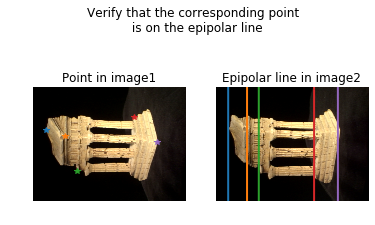

In [11]:
displayEpipolarF(im1, im2, F8, [54, 135, 186, 423, 522], [183, 209, 355, 128, 231])

### 3D Scene Structure

Let us now compute the camera matrices and triangulate the 2D points to obtain the 3D scene
structure. To obtain the Euclidean scene structure, first convert the fundamental matrix $\boldsymbol{F}$
to an essential matrix $\boldsymbol{E}$. The internal camera calibration matrices $\boldsymbol{K}_1$ and 
$\boldsymbol{K}_2$ are known; these are provided in `data/intrinsics.npz`.

In [12]:
intrinsic = np.load('./data/temple_intrinsics.npz')
K1, K2 = intrinsic['K1'], intrinsic['K2']

Given an essential matrix, it is possible to retrieve the projective camera matrices $\boldsymbol{M}_1$ and
$\boldsymbol{M}_2$ from it. Assuming $\boldsymbol{M}_1$ is fixed at $[\boldsymbol{I}, 0]$, $\boldsymbol{M}_2$ can be retrieved up to a scale and four-fold rotation ambiguity.

We have provided you with the function `camera2` to recover the four possible $\boldsymbol{M}_2$ matrices given $\boldsymbol{E}$.
Note: The $\boldsymbol{M}_1$ and $\boldsymbol{M}_2$ here are projection matrices of the form: $\boldsymbol{M}_1 = [\boldsymbol{I}|0]$ and $\boldsymbol{M}_2 = [\boldsymbol{R}|\boldsymbol{t}]$.

In [13]:
def camera2(E):
    U, S, V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U.dot(np.array([[m, 0, 0], [0, m, 0], [0, 0, 0]])).dot(V)
    U, S, V = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    if np.linalg.det(U.dot(W).dot(V)) < 0:
        W = -W

    return np.dstack([
        np.concatenate(
            [U.dot(W).dot(V), U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()],
            axis=1),
        np.concatenate(
            [U.dot(W).dot(V), -U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()],
            axis=1),
        np.concatenate(
            [U.dot(W.T).dot(V), U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()],
            axis=1),
        np.concatenate([
            U.dot(W.T).dot(V), -U[:, 2].reshape([-1, 1]) / abs(U[:, 2]).max()
        ],
                       axis=1)
    ])

<a name="q2"></a>
### Essential Matrix [20 points]

Write a function to compute the essential matrix $\boldsymbol{E}$ given $\boldsymbol{F}$, $\boldsymbol{K}_1$ and $\boldsymbol{K}_2$

In [14]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
def essentialMatrix(F, K1, K2): 
    
    # F = (K2**-1).T * E * (K1**-1)
    # K1.T * F = K1.T * (K2**-1).T * E * (K1**-1)   
    # K1.T * F = (K2**-1).T * E  
    # K1.T * F * K2 = (K2**-1).T * E * K2  
    # K1.T * F * K2 = E
    # so  
    # E = K1.T * F * K2 
    E = np.dot(K1.T,np.dot(F,K2)) 
    return E

# YOUR CODE HERE 

def mytest_essentialMatrix():   
    
    actual = essentialMatrix(F8, K1, K2)
    
    expected = np.array([[ 2.26268685e-03, -3.06552495e-01,  1.66260633e+00],
                         [-1.33130407e-01,  6.91061098e-03, -4.33003420e-02],
                         [-1.66721070e+00, -1.33210351e-02, -6.72186431e-04]])
    
    assert(actual.shape == expected.shape) 
    tolerance = 0.1**7
    print('Results matched expectations to a tolerance of', tolerance, '?', np.allclose(actual, expected, atol = tolerance)) 
    
mytest_essentialMatrix()
print('done')

Results matched expectations to a tolerance of 1.0000000000000004e-07 ? True
done


<a name="q3"></a>
#### Epipolar correspondence [0 points]

In [15]:
coords = np.load('./data/temple_coords.npz')
x1, y1 = coords['x1'][:, 0], coords['y1'][:, 0]

In order to create a 3D visualization of the temple images, we will treat our two images as
a stereo-pair. We can then triangulate corresponding points in each image and render their 3D
locations.

Variables `x1` and `y1` contain the $x$ and $y$ coordinates of a single 2D point in the first image that
we want to 3D reconstruct.

We want to implement a function that takes in the $x$ and $y$ coordinates of a pixel in the first image and the
fundamental matrix $F$, and returns the coordinates of the pixel in the second image which corresponds
to the input point. The match is obtained by computing the similarity of a small window around the
$(x_1, y_1)$ coordinates in `im1` to various windows around possible matches in `im2` and returning the
closest.

Instead of searching for the matching point at every possible location in `im2`, we can use
$F$ and simply search over the set of pixels that lie along the epipolar line (recall that the
epipolar line passes through a single point in `im2` which corresponds to the point $(x_1, y_1)$ in
`im1`).

There are various possible ways to compute the window similarity, but simple methods such as the Euclidean or Manhattan distances between the intensity of the pixels should suffice.

If you want to experiment with this:
- Try various window sizes.
- It may help to use a Gaussian weighting of the window, so that the center has greater influence than the periphery.
- Since the two images only differ by a small amount, it might be beneficial to consider matches for which the distance from $(x_1, y_1)$ to $(x_2, y_2)$ is small.

To help you test your `epipolarCorrespondence`, we have included a helper function `epipolarMatchGUI`,
which takes in two images and the fundamental matrix.

In [16]:
def _epipoles(E):
    U, S, V = np.linalg.svd(E)
    e1 = V[-1, :]
    U, S, V = np.linalg.svd(E.T)
    e2 = V[-1, :]
    return e1, e2

def epipolarMatchGUI(I1, I2, F):
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('Select a point in this image')
    ax1.set_axis_off()
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image')
    ax2.set_axis_off()

    pts1 = []
    pts2 = []

    def onclick(event, pts1, pts2):
        print('click')
        x1 = event.xdata
        y1 = event.ydata

        if not x1 or not y1:
            return

        v = np.array([x1, y1, 1])
        l = F.dot(v)
        s = np.sqrt(l[0]**2+l[1]**2)

        if s==0:
            error('Zero line vector in epipolarMatchGUI')

        l = l/s

        if l[0] != 0:
            ye = sy-1
            ys = 0
            xe = -(l[1] * ye + l[2])/l[0]
            xs = -(l[1] * ys + l[2])/l[0]
        else:
            xe = sx-1
            xs = 0
            ye = -(l[0] * xe + l[2])/l[1]
            ys = -(l[0] * xs + l[2])/l[1]

        ax1.plot(x1, y1, '*', MarkerSize=6, linewidth=2)
        ax2.plot([xs, xe], [ys, ye], linewidth=2)
        plt.draw()

        # draw points
        x2, y2 = sub.epipolarCorrespondence(I1, I2, F, x1, y1)

        # Add error handler. Could return None, if input point is not desired
        # (e.g. if it is at the corner, we will not be able to extract image patch for comparison)
        if not y1 or not y2:
            return

        ax2.plot(x2, y2, 'ro', MarkerSize=8, linewidth=2)
        plt.draw()

        pts1.append([x1, y1])
        pts2.append([x2, y2])

    f.canvas.mpl_connect('button_press_event', lambda event: onclick(event, pts1, pts2))
    plt.show()

    return (np.stack(pts1), np.stack(pts2)) if len(pts1) > 0 else ([], [])

In [17]:
def epipolarCorrespondence(im1, im2, F, x1, y1, window_size = 11, sigma = 5, search_range = 40):
    # set the size of the window
    x1, y1 = int(round(x1)), int(round(y1))
    center = window_size // 2

    # create gaussian weight matrix
    mask = np.ones((window_size, window_size)) * center
    mask = np.repeat(np.array([range(window_size)]), window_size,
                     axis=0) - mask
    mask = np.sqrt(mask**2 + np.transpose(mask)**2)
    weight = np.exp(-0.5 * (mask**2) / (sigma**2))
    weight /= np.sum(weight)
    #print('weight:\n',weight)

    if len(im1.shape) > 2:
        weight = np.repeat(np.expand_dims(weight, axis=2),
                           im1.shape[-1],
                           axis=2)

    # get the epipolar line
    p = np.array([[x1], [y1], [1]])
    l2 = np.dot(F, p)
    #print('l2:', l2)

    # get the patch around the pixel in image1
    patch1 = im1[y1 - center:y1 + center + 1, x1 - center:x1 + center + 1]
    
    # get the points on the epipolar line
    h, w, _ = im2.shape
    
    Y = np.array(range(y1 - search_range, y1 + search_range))
    # print('Y:', Y)
    
    X = np.round(-(l2[1] * Y + l2[2]) / l2[0]).astype(int)
    # print('X:', X)
    
    # limit X and Y so we do not run into edges and run out of space for patch
    valid = (X >= center) & (X < w - center) & (Y >= center) & (Y < h - center)
    X, Y = X[valid], Y[valid]
    #print('center:', center) 
    #print('w:', w) 
    #print('Y valid:', Y) 
    #print('X valid:', X)

    min_dist = None
    x2, y2 = None, None
    for i in range(len(X)):
        # get the patch around the pixel in image2
        patch2 = im2[Y[i] - center:Y[i] + center + 1,
                     X[i] - center:X[i] + center + 1]
        # calculate the distance
        dist = np.sum((patch1 - patch2)**2 * weight)
        if min_dist is None or dist < min_dist:
            min_dist = dist
            x2, y2 = X[i], Y[i]

    return x2, y2


def mytest_epipolarCorrespondence():   
    
    foo = epipolarCorrespondence(_im1, _im2, F8, _pts1[12][0], _pts1[12][1]) 
    print('foo:', foo) 
    
    """
    expected = np.array([[ 2.26268685e-03, -3.06552495e-01,  1.66260633e+00],
                         [-1.33130407e-01,  6.91061098e-03, -4.33003420e-02],
                         [-1.66721070e+00, -1.33210351e-02, -6.72186431e-04]])
    
    assert(actual.shape == expected.shape) 
    tolerance = 0.1**7
    print('Results matched expectations to a tolerance of', tolerance, '?', np.allclose(actual, expected, atol = tolerance)) 
    """

#epipolarMatchGUI(_im1, _im2, F8)
#mytest_epipolarCorrespondence()
print('done')



foo: (189, 334)
done


In [18]:
SP1, SP2 = [], []
for i in range(x1.shape[0]):
    x2, y2 = epipolarCorrespondence(im1, im2, F8, x1[i], y1[i])
    SP1.append([x1[i], y1[i]])
    SP2.append([x2, y2])
SP1 = np.array(SP1)
SP2 = np.array(SP2)

<a name="q4"></a>
#### Triangulation [20 points]

Write a function to triangulate a set of 2D coordinates in the image to a set of 3D points
where `pts1` and `pts2` are the $N \times 2$ matrices with the 2D image coordinates and `w` is an 
$N \times 3$ matrix with the corresponding 3D points per row. `C1` and `C2` are the $3 \times 4$ 
camera matrices. Remember that you will need to multiply the given intrinsics matrices with your
solution for the canonical camera matrices to obtain the final camera matrices. Various methods exist
for triangulation - we will be using least squares here using **SVD**.

The function will be used as follows:

In [19]:
M1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
C1 = np.dot(K1, M1)

E = essentialMatrix(F8, K1, K2)

M2s = camera2(E)
M2, P = None, None

# for i in range(M2s.shape[-1]):
#     M2_ = M2s[:, :, i]
#     C2_ = np.dot(K2, M2_)
#     w, err = triangulate(C1, SP1, C2_, SP2)
# 
#     if np.min(w[:, -1]) > 0:
#         M2 = M2_
#         P = w
#         break
# 
# C2 = np.dot(K2, M2)
#
# P, err = triangulate(C1, SP1, C2, SP2)
# print("Triangulation error:", err)

In [20]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
def triangulate(C1, pts1, C2, pts2):
    x1, y1 = pts1[:, 0], pts1[:, 1]
    x2, y2 = pts2[:, 0], pts2[:, 1]
    
    # C1 and C2 are the  3×4 camera matrices
    A1 = np.vstack(
        (C1[0, 0] - C1[2, 0] * x1, C1[0, 1] - C1[2, 1] * x1,
         C1[0, 2] - C1[2, 2] * x1, C1[0, 3] - C1[2, 3] * x1)).transpose()
    A2 = np.vstack(
        (C1[1, 0] - C1[2, 0] * y1, C1[1, 1] - C1[2, 1] * y1,
         C1[1, 2] - C1[2, 2] * y1, C1[1, 3] - C1[2, 3] * y1)).transpose()
    A3 = np.vstack(
        (C2[0, 0] - C2[2, 0] * x2, C2[0, 1] - C2[2, 1] * x2,
         C2[0, 2] - C2[2, 2] * x2, C2[0, 3] - C2[2, 3] * x2)).transpose()
    A4 = np.vstack(
        (C2[1, 0] - C2[2, 0] * y2, C2[1, 1] - C2[2, 1] * y2,
         C2[1, 2] - C2[2, 2] * y2, C2[1, 3] - C2[2, 3] * y2)).transpose()

    # calculate the 3D coordinates for each point
    
    N = pts1.shape[0] # pts1 is 𝑁×2
    
    # w contains N rows of 3D homogenious coordinates, so it is Nx4
    w = np.zeros((N,3))
    
    for ind in range(N): # i.e. for each point in pts1
        
        A = np.vstack((A1[ind, :], A2[ind, :], A3[ind, :], A4[ind, :])) 
        
        # Various methods exist for triangulation - we will be using least squares here using SVD.
        _, _, vh = np.linalg.svd(A) 
        
        # Extract the desired valure from the last column of v,
        # which is the last row of the vh,
        # under the premise that the last column is the 
        # least singular value
        p = vh[-1, :]  
         
        # Normalize to make it homogeneous 
        p /= p[3] 
        
        # to change coordinate system remove last value.
        # The removed value is p[3], which after normalization has value of 1. 
        p = p[:3]   
        
        w[ind, :] = p  

    # project to 2D points
    W = np.hstack((w, np.ones((N, 1))))
    err = 0
    for i in range(N):
        proj1 = np.dot(C1, np.transpose(W[i, :]))
        proj2 = np.dot(C2, np.transpose(W[i, :]))
        proj1 = np.transpose(proj1[:2] / proj1[-1])
        proj2 = np.transpose(proj2[:2] / proj2[-1])
        # compute error
        err += np.sum((proj1 - pts1[i])**2 + (proj2 - pts2[i])**2)

    return w, err

# YOUR CODE HERE 

def mytest_triangulation():
    M1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
    C1 = np.dot(K1, M1)
    C2 = np.dot(K2, M2s[:, :, 2])
    P, err = triangulate(C1, SP1, C2, SP2)
    print("Triangulation error:", err)
    print(P[:10])

    #Triangulation error: 727.4355376854296
    expected = np.array([[-0.59639537, -0.15423095,  3.68221248],
                         [-0.58867492, -0.18526043 , 3.72400892],
                         [-0.57893586, -0.20791232 , 3.69289864],
                         [-0.57053886, -0.23546683 , 3.66975595],
                         [-0.56313427, -0.261986   , 3.63727892],
                         [-0.53692093, -0.27159488 , 3.63834014],
                         [-0.56628692, -0.30746193 , 4.15534704],
                         [-0.48127291, -0.28738727 , 3.78370902],
                         [-0.45627965, -0.29889654 , 3.80402412],
                         [-0.41042319, -0.29646226 , 3.74207664]])
    
    tolerance = 0.1**7
    print('Results matched expectations to a tolerance of', tolerance, '?', np.allclose(P[:10], expected, atol = tolerance)) 

########
    
#mytest_triangulation()

Triangulation error: 727.4355376854296
[[-0.59639537 -0.15423095  3.68221248]
 [-0.58867492 -0.18526043  3.72400892]
 [-0.57893586 -0.20791232  3.69289864]
 [-0.57053886 -0.23546683  3.66975595]
 [-0.56313427 -0.261986    3.63727892]
 [-0.53692093 -0.27159488  3.63834014]
 [-0.56628692 -0.30746193  4.15534704]
 [-0.48127291 -0.28738727  3.78370902]
 [-0.45627965 -0.29889654  3.80402412]
 [-0.41042319 -0.29646226  3.74207664]]
Results matched expectations to a tolerance of 1.0000000000000004e-07 ? True


In [21]:
for i in range(M2s.shape[-1]):
    M2_ = M2s[:, :, i]
    C2_ = np.dot(K2, M2_)
    w, err = triangulate(C1, SP1, C2_, SP2)

    if np.min(w[:, -1]) > 0:
        M2 = M2_
        P = w
        break

C2 = np.dot(K2, M2)
P, err = triangulate(C1, SP1, C2, SP2)
print("Triangulation error:", err)

Triangulation error: 727.4355376854296


Let us now visualize the result in 3D

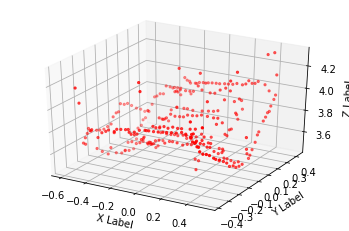

In [22]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2], c='r', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<a name="part-2"></a>
## Camera calibration and  3D reconstruction

In this part of the assignment, we will not be given the camera intrinsic matrices. Instead we will use images of a checkerboard pattern captured by two cameras to obtain the camera intrinsic matrices.

Let us first start by visualizing the two images we will be working with

In [23]:
import cv2

im1 = cv2.imread(str(root / "data" / "cam1.jpg"))
im2 = cv2.imread(str(root / "data" / "cam2.jpg"))
M = np.max(im1.shape)

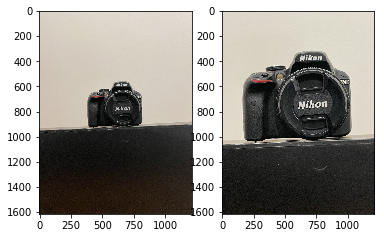

In [24]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.show()

Did you notice the part where we used the `cvtColor` function with the argument `COLOR_BGR2RGB`? It is because we used the OpenCV library (`cv2`) to load the image and OpenCV uses Blue-Green-Red (BGR) as the order of the 3 channels of the color image when it loads it from disk. Matplotlib, on the other hand, expects RGB and so we have to convert from BGR to RGB.

In order to perform camera calibration, we will be using images of a checkerboard pattern captured by the two cameras. Let us load the checkerboard images.

In [25]:
from glob import glob

img1x = [cv2.imread(str(img)) for img in glob(str(root / "data" / "1x" / "*.jpg"))]
img2x = [cv2.imread(str(img)) for img in glob(str(root / "data" / "2x" / "*.jpg"))]

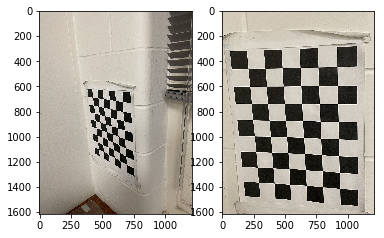

In [26]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(img1x[0], cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(img2x[0], cv2.COLOR_BGR2RGB))
plt.show()

Let us now define the dimensions of checkerboard. We only use points that lie inside the checkerboard and not the edge points because of how the OpenCV function that we will be using works. We also define a criteria that will tell the OpenCV subpixel refining algorithm when to stop. `objpoints1x` is a vector to store vectors of 3D points for each checkerboard image in the `1x` folder. We will use `objp` for this which we populate here for you. `imgpoints1x` is a vector to store vectors of 2D points for each checkerboard image in the `1x` folder which we will get from OpenCV. Similarly for images in the `2x` folder.

In [27]:
CHECKERBOARD = (6,8)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)

objpoints1x, objpoints2x = [], []
imgpoints1x, imgpoints2x = [], []

# world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
#print(objp.shape)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
#print(objp.shape)
#print(objp)

<a name="q5"></a>
## Checkerboard pattern detection and Camera Calibration [15 points]

- Use the OpenCV function [`findChessboardCorners`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) to find the checkerboard pattern in every image in the `1x` folder and append them to `imgpoints1x`. For every $6 \times 8 = 48$ points you append to imgpoints1x, append `objp` to `objpoints1x` as well. Do the same with `imgpoints2x` and `objpoints2x`.

- Use the OpenCV function [`cornerSubPix`](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e) to refine the detected points further. Play with the criteria defination above till you get a result you are happy with.

- You can use the OpenCV function [`drawChessboardCorners`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022) to visualize the output of the `findChessboardCorners` function.

- Use the OpenCV function [`calibrateCamera`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) to use the 4 arrays above to get the intrinsic matrices $\boldsymbol{K}_1$ and $\boldsymbol{K}_2$


In [28]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 0.0001)
objpoints1x, objpoints2x = [], []
imgpoints1x, imgpoints2x = [], []

### print(len(img1x)) is 8
for img in img1x:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    # print(corners.shape) seems to always be 48 x 1 x 2
    if ret == True:
        objpoints1x.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints1x.append(corners2) 
        
###  print(len(img2x)) is 9
for img in img2x:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        objpoints2x.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints2x.append(corners2) 

#DONE: uncomment these lines and replace the 'xxxxxxx' terms with the object points and image points for each image 
#      to obtain the intrinsic matrices K_1 and K_2. The two "None" terms in each line should remain.        
_, K1, _, _, _ = cv2.calibrateCamera(objpoints1x, imgpoints1x, img1x[0].shape[:-1][::-1], None, None)
_, K2, _, _, _ = cv2.calibrateCamera(objpoints2x, imgpoints2x, img2x[0].shape[:-1][::-1], None, None)

# YOUR CODE HERE 

def mytest_derive_intrinsic_arrays(K1,K2):

    expected_K1 = np.array([[1.22428783e+03, 0.00000000e+00, 6.15564824e+02],
                            [0.00000000e+00, 1.22269413e+03, 8.24825336e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

    expected_K2 = np.array([[2.46781874e+03, 0.00000000e+00, 6.50802283e+02],
                            [0.00000000e+00, 2.47070439e+03, 9.25846506e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

    tolerance = 0.1**7
    print('K1 Results matched expectations to a tolerance of', tolerance, '?', np.allclose(K1, expected_K1, atol = tolerance)) 
    print('K2 Results matched expectations to a tolerance of', tolerance, '?', np.allclose(K2, expected_K2, atol = tolerance)) 

#mytest_derive_intrinsic_arrays(K1,K2) 

<a name="q6"></a>
## Feature descriptor matching and Fundamental Matrix estimation [15 points]

Let us implement the rest of the code, similar to the previous parts of this assignment.
For this, we need to get point correspondences between the two images, but we do not have
that provided either. Let us use a keypoint detector that uses a feature descriptor
([ORB](http://www.gwylab.com/download/ORB_2012.pdf)) to get image features and match them
between the two images. We will use the `scikit-image` library functions to do this. In a
previous assignment you implemented RANSAC to be robust to outliers. We will use RANSAC
here again as the feature matching is inherently noisy and a voting algorithm like RANSAC
helps a lot. We will use the built-in `scikit-image` function `ransac` instead of implementing it 
ourselves.

In [29]:
from skimage.measure import ransac
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.transform import FundamentalMatrixTransform
np.random.seed(1)

- Use [`skimage.feature.ORB`](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.ORB)
and [`skimage.feature.match_descriptors`](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.match_descriptors)
to find and match feature descriptors.
- Use [`skimage.measure.ransac`](https://scikit-image.org/docs/dev/api/skimage.measure.html#ransac)
with appropriate arguments to run RANSAC with the 
[`skimage.transform.FundamentalMatrixTransform`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.FundamentalMatrixTransform)
to estimate the Fundamental Matrix directly.
Note: If you use the `FunamentalMatrixTransform` with skimage's `ransac` function, the model returned alread has the fundamental matrix as parameter.
- You can use [`skimage.feature.plot_matches`](https://scikit-image.org/docs/stable/api/skimage.feature.html#plot-matches)
to visualize the matching before or after running RANSAC and getting inliers.
- Calculate the Fundamental and Essential Matrices and store them in `F8` and `E` respectively. You can use functions you have defined earlier in the assignment to achieve this along with the intrinsic matrices you just computed.
- Play with the arguments to the keypoint detection and matching calls as well as the `ransac` call to get good inliers and thus accurate estimates of Fundamental and Essential matrices.

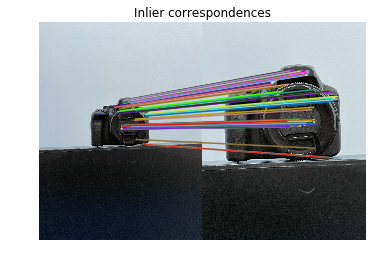

------------
[[ 1.40062674e-07 -1.86049907e-05  8.50261307e-03]
 [ 1.85852649e-05  3.28085238e-08 -1.53278362e-02]
 [-6.08520484e-03  1.56475091e-02 -2.23439970e+00]]
F8 Results matched expectations to a tolerance of 1.0000000000000004e-07 ? True
------------
E:
 [[  0.42317422 -56.13846613 -16.67514254]
 [ 56.21770007   0.09911179  -9.53775792]
 [ 13.72800168   4.36466875  -1.04535279]]
E Results matched expectations to a tolerance of 1.0000000000000004e-07 ? True
E Results matched expectations to a tolerance of 0.1 ? True
E Results matched expectations to a tolerance of 1.0 ? True
------------
done


In [34]:
### GRADED
### YOUR ANSWER BELOW

### YOUR SOLUTION HERE
np.random.seed(0) #for repeatable random values so your results can be compared for testing

bim1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
bim2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

detector1 = ORB(n_scales=10, n_keypoints=1000) #try different values here
detector2 = ORB(n_scales=10, n_keypoints=1000) #try different values here
detector1.detect_and_extract(bim1)
detector2.detect_and_extract(bim2)
matches = match_descriptors(detector1.descriptors, detector2.descriptors)
points1 = detector1.keypoints
points2 = detector2.keypoints
model, inliers = ransac((points1[matches[:, 0]], points2[matches[:, 1]]),
                        FundamentalMatrixTransform,
                        min_samples=8,           #try different values here
                        residual_threshold=0.3,  #try different values here
                        max_trials=10000)        #try different values here

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
plot_matches(ax,
             im1,
             im2,
             points1,
             points2,
             matches[inliers],
             only_matches=True)
ax.axis("off")
ax.set_title("Inlier correspondences")
plt.show()

points1 = np.stack(
    [points1[matches[inliers, 0], 1], points1[matches[inliers, 0], 0]], 1)
points2 = np.stack(
    [points2[matches[inliers, 1], 1], points2[matches[inliers, 1], 0]], 1)
F8 = model.params

#the fundamental matrix, intrinsic matrix 1, and intrinsic matrix 2
E = essentialMatrix(F8, K2, K1)

def mytest_FDM_and_FME (F8,E):
    print('------------')
    expected_F8 = np.array([[ 1.40062674e-07, -1.86049907e-05,  8.50261307e-03],
                            [ 1.85852649e-05,  3.28085238e-08, -1.53278362e-02],
                            [-6.08520484e-03,  1.56475091e-02, -2.23439970e+00]]) 

    print(F8) #view your fundamental matrix, ok
    tolerance = 0.1**7
    print('F8 Results matched expectations to a tolerance of', tolerance, '?', np.allclose(F8, expected_F8, atol = tolerance)) 

    print('------------')
    expected_E = np.array( [[ 0.42317422, -56.13846613, -16.67514254],
                            [ 56.21770007, 0.09911179, -9.53775792],
                            [ 13.72800168, 4.36466875, -1.04535279]]) 

    print('E:\n',E)  #view your essential matrix, not matching expected valuesprint('------------')
    print('E Results matched expectations to a tolerance of', tolerance, '?', np.allclose(E, expected_E, atol = tolerance)) 
    tolerance = 0.1 
    print('E Results matched expectations to a tolerance of', tolerance, '?', np.allclose(E, expected_E, atol = tolerance)) 
    tolerance = 1.0 
    print('E Results matched expectations to a tolerance of', tolerance, '?', np.allclose(E, expected_E, atol = tolerance)) 
    print('------------')

# YOUR CODE HERE 
#mytest_FDM_and_FME(F8,E)
print('done')

Let us now run the rest of the script to visualize the results.

Triangulation error: 2583.835897336685


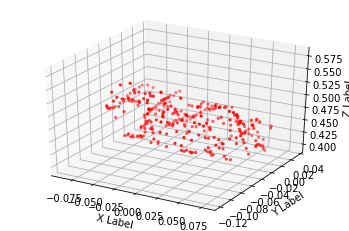

In [31]:
coords = np.load(root / "data" / "camera_coords.npz")
x1, y1 = coords['x1'][:, 0]/2.5, coords['y1'][:, 0]/2.5
SP1, SP2 = [], []
for i in range(x1.shape[0]):
    x2, y2 = epipolarCorrespondence(im1, im2, F8, x1[i], y1[i], window_size = 41, search_range = 70)
    SP1.append([x1[i], y1[i]])
    SP2.append([x2, y2])
SP1 = np.array(SP1)
SP2 = np.array(SP2)
M1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
C1 = np.dot(K1, M1)
M2s = camera2(E)

M2, P = None, None

for i in range(M2s.shape[-1]):
    M2_ = M2s[:, :, i]
    C2_ = np.dot(K2, M2_)
    w, err = triangulate(C1, SP1, C2_, SP2)

    if np.min(w[:, -1]) > 0:
        M2 = M2_
        P = w
        break

C2 = np.dot(K2, M2)
P, err = triangulate(C1, SP1, C2, SP2)
print("Triangulation error:", err)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2], c='r', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<a name="part-3"></a>
## Challenge Problems

1. Notice how the Triangulation error in this case is much higher compared to last time
when the point correspondences and camera intrinsics were known. This can be fixed using
something known as [Bundle Adjustment](https://en.wikipedia.org/wiki/Bundle_adjustment)
which is outside the scope of this assignment. Feel free to read it up and post your 
results/findings in the forum.

2. The images used here are of a complex object (a DSLR camera). We provide a simpler
object pair in the assignment folder named `mug1.jpg` and `mug2.jpg` captured using the
same pair of cameras. Try to get 3D reconstruction results similar to what what we got
here on that image pair. Post your results in the forums.
Note: 2D coordinates are not provided for the pair. You will have to select some points
that would best describe the object. You can use the matplotlib function
[`ginput`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ginput.html)
to get points on an image interactively.

3. If you have a smartphone with multiple cameras, try to capture image pairs with the
different cameras and 3D reconstruct objects in the image pairs. You will have to capture
the checkerboard pattern with the cameras similar to what we did above to get camera
intrinsics. Post your 3D reconstructed objects in the forums.